In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Load the data we collected
results = pd.read_csv('../data/race_results_2022_2025.csv')
quali = pd.read_csv('../data/qualifying_2022_2025.csv')

print(f"Results: {results.shape}")
print(f"Qualifying: {quali.shape}")

Results: (1838, 11)
Qualifying: (1839, 9)


In [2]:
# Merge qualifying times into race results
df = results.merge(
    quali[['Abbreviation', 'Year', 'RaceNumber', 
           'QualiPosition', 'BestQualiTime']],
    on=['Abbreviation', 'Year', 'RaceNumber'],
    how='left'
)

# Sort chronologically so rolling features work correctly
df = df.sort_values(['Year', 'RaceNumber', 'Abbreviation']).reset_index(drop=True)

print(f"Merged dataset: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

# Preview
df.head()

Merged dataset: (1838, 13)

Columns: ['DriverNumber', 'Abbreviation', 'TeamName', 'GridPosition', 'Position', 'Status', 'Points', 'Year', 'RaceNumber', 'EventName', 'CircuitName', 'QualiPosition', 'BestQualiTime']


,DriverNumber,Abbreviation,TeamName,GridPosition,Position,Status,Points,Year,RaceNumber,EventName,CircuitName,QualiPosition,BestQualiTime
0,23,ALB,Williams,14.0,13.0,Finished,0.0,2022,1,Bahrain Grand Prix,Sakhir,14.0,92.664
1,14,ALO,Alpine,8.0,9.0,Finished,2.0,2022,1,Bahrain Grand Prix,Sakhir,8.0,92.195
2,77,BOT,Alfa Romeo,6.0,6.0,Finished,8.0,2022,1,Bahrain Grand Prix,Sakhir,6.0,91.560
3,10,GAS,AlphaTauri,10.0,20.0,Power Unit,0.0,2022,1,Bahrain Grand Prix,Sakhir,10.0,92.338
4,44,HAM,Mercedes,5.0,3.0,Finished,15.0,2022,1,Bahrain Grand Prix,Sakhir,5.0,91.238


Driver form features added:
  Abbreviation  Year  RaceNumber  AvgFinishLast5  AvgQualiLast5  PointsLast3
0          ALB  2022           1             NaN            NaN          NaN
1          ALO  2022           1             NaN            NaN          NaN
2          BOT  2022           1             NaN            NaN          NaN
3          GAS  2022           1             NaN            NaN          NaN
4          HAM  2022           1             NaN            NaN          NaN
5          HUL  2022           1             NaN            NaN          NaN
6          LAT  2022           1             NaN            NaN          NaN
7          LEC  2022           1             NaN            NaN          NaN
8          MAG  2022           1             NaN            NaN          NaN
9          MSC  2022           1             NaN            NaN          NaN
Qualifying gap distribution:
count    1819.000000
mean        1.670733
std         2.785282
min         0.000000
25%         

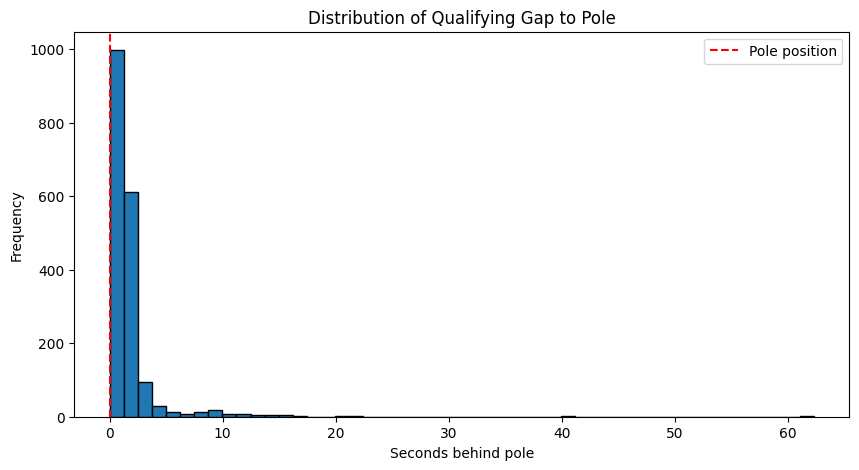

In [11]:
# Calculate rolling averages PER DRIVER across races
# shift(1) prevents data leakage — we only use past races

# Average finish position in last 5 races
df['AvgFinishLast5'] = (
    df.groupby('Abbreviation')['Position']
    .transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean())
)

# Average qualifying position in last 5 races
df['AvgQualiLast5'] = (
    df.groupby('Abbreviation')['QualiPosition']
    .transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean())
)

# Points scored in last 3 races (momentum indicator)
df['PointsLast3'] = (
    df.groupby('Abbreviation')['Points']
    .transform(lambda x: x.shift(1).rolling(3, min_periods=1).sum())
)

print("Driver form features added:")
print(df[['Abbreviation', 'Year', 'RaceNumber', 
          'AvgFinishLast5', 'AvgQualiLast5', 'PointsLast3']].head(10))

# How many seconds behind the fastest qualifier?
pole_times = df.groupby(['Year', 'RaceNumber'])['BestQualiTime'].min().reset_index()
pole_times.columns = ['Year', 'RaceNumber', 'PoleTime']

df = df.merge(pole_times, on=['Year', 'RaceNumber'])
df['QualiGapToPole'] = df['BestQualiTime'] - df['PoleTime']

# Check it worked
print("Qualifying gap distribution:")
print(df['QualiGapToPole'].describe())

# Visualize
plt.figure(figsize=(10, 5))
plt.hist(df['QualiGapToPole'], bins=50, edgecolor='black')
plt.xlabel('Seconds behind pole')
plt.ylabel('Frequency')
plt.title('Distribution of Qualifying Gap to Pole')
plt.axvline(0, color='red', linestyle='--', label='Pole position')
plt.legend()
plt.show()

In [4]:
# Team/car performance in recent races

# Constructor average finish in last 3 races
df['ConstructorAvgFinishLast3'] = (
    df.groupby('TeamName')['Position']
    .transform(lambda x: x.shift(1).rolling(3, min_periods=1).mean())
)

# Constructor podium rate this season
df['Podium'] = (df['Position'] <= 3).astype(int)
df['ConstructorPodiumRateSeason'] = (
    df.groupby(['TeamName', 'Year'])['Podium']
    .transform(lambda x: x.shift(1).expanding().mean())
)

print("Constructor features:")
print(df[['TeamName', 'Year', 'RaceNumber', 
          'ConstructorAvgFinishLast3', 'ConstructorPodiumRateSeason']].head(10))

Constructor features:
       TeamName  Year  RaceNumber  ConstructorAvgFinishLast3  \
0      Williams  2022           1                        NaN   
1        Alpine  2022           1                        NaN   
2    Alfa Romeo  2022           1                        NaN   
3    AlphaTauri  2022           1                        NaN   
4      Mercedes  2022           1                        NaN   
5  Aston Martin  2022           1                        NaN   
6      Williams  2022           1                       13.0   
7       Ferrari  2022           1                        NaN   
8  Haas F1 Team  2022           1                        NaN   
9  Haas F1 Team  2022           1                        5.0   

   ConstructorPodiumRateSeason  
0                          NaN  
1                          NaN  
2                          NaN  
3                          NaN  
4                          NaN  
5                          NaN  
6                          0.0  
7        

In [5]:
# Driver's historical performance at THIS specific circuit

df['DriverCircuitAvgFinish'] = (
    df.groupby(['Abbreviation', 'CircuitName'])['Position']
    .transform(lambda x: x.shift(1).expanding().mean())
)

df['DriverCircuitBestFinish'] = (
    df.groupby(['Abbreviation', 'CircuitName'])['Position']
    .transform(lambda x: x.shift(1).expanding().min())
)

# Fill NaN (first time at circuit) with driver's overall season average
df['DriverCircuitAvgFinish'] = df['DriverCircuitAvgFinish'].fillna(df['AvgFinishLast5'])
df['DriverCircuitBestFinish'] = df['DriverCircuitBestFinish'].fillna(20)  # Neutral value

print("Circuit-specific features:")
print(df[df['CircuitName'] == 'Monaco'][
    ['Abbreviation', 'Year', 'DriverCircuitAvgFinish', 'Position']
].head(10))

Circuit-specific features:
    Abbreviation  Year  DriverCircuitAvgFinish  Position
120          ALB  2022                   12.40      18.0
121          ALO  2022                   14.40       7.0
122          BOT  2022                    8.20       9.0
123          GAS  2022                   12.00      11.0
124          HAM  2022                    7.60       8.0
125          LAT  2022                   16.00      15.0
126          LEC  2022                    6.20       4.0
127          MAG  2022                   13.00      20.0
128          MSC  2022                   14.75      19.0
129          NOR  2022                    8.40       6.0


In [6]:
# Did Not Finish indicator
df['DNF'] = (~df['Status'].isin(['Finished', '+1 Lap', '+2 Laps'])).astype(int)

# DNF rate this season (driver error + mechanical)
df['DNFRateSeason'] = (
    df.groupby(['Abbreviation', 'Year'])['DNF']
    .transform(lambda x: x.shift(1).expanding().mean())
).fillna(0)

# Podium rate this season
df['PodiumRateSeason'] = (
    df.groupby(['Abbreviation', 'Year'])['Podium']
    .transform(lambda x: x.shift(1).expanding().mean())
).fillna(0)

print("Reliability features:")
print(df.groupby('Abbreviation')[['DNFRateSeason', 'PodiumRateSeason']].mean().sort_values('DNFRateSeason', ascending=False).head(10))

Reliability features:
              DNFRateSeason  PodiumRateSeason
Abbreviation                                 
SAR                0.703150          0.000000
DEV                0.584127          0.000000
BOR                0.579017          0.000000
ZHO                0.524222          0.000000
BOT                0.504247          0.000000
HUL                0.463118          0.009922
MAG                0.450335          0.000000
COL                0.449391          0.000000
RIC                0.445930          0.000000
GAS                0.379033          0.007377


In [7]:
# Where does this team stand in the constructor standings?

# Calculate cumulative constructor points at each race
df['CumConstructorPoints'] = (
    df.groupby(['TeamName', 'Year'])['Points']
    .transform(lambda x: x.shift(1).cumsum().fillna(0))
)

# Rank constructors at each race (1 = leading team)
df['ConstructorChampPos'] = (
    df.groupby(['Year', 'RaceNumber'])['CumConstructorPoints']
    .rank(ascending=False, method='min')
)

print("Constructor standings feature:")
print(df[df['Year'] == 2024].groupby('TeamName')['ConstructorChampPos'].mean().sort_values())

Constructor standings feature:
TeamName
Red Bull Racing     2.520833
McLaren             3.854167
Ferrari             4.000000
Mercedes            7.333333
Aston Martin        9.020833
RB                 11.833333
Haas F1 Team       12.458333
Alpine             14.270833
Williams           15.680851
Kick Sauber        17.291667
Name: ConstructorChampPos, dtype: float64


Feature correlations with finish position:
Position                       1.000000
QualiPosition                  0.647320
GridPosition                   0.611292
AvgQualiLast5                  0.597750
AvgFinishLast5                 0.574505
ConstructorChampPos            0.532227
ConstructorAvgFinishLast3      0.496220
DriverCircuitAvgFinish         0.469250
DNFRateSeason                  0.397979
QualiGapToPole                 0.179500
ConstructorPodiumRateSeason   -0.505832
PodiumRateSeason              -0.513175
PointsLast3                   -0.569799
Name: Position, dtype: float64


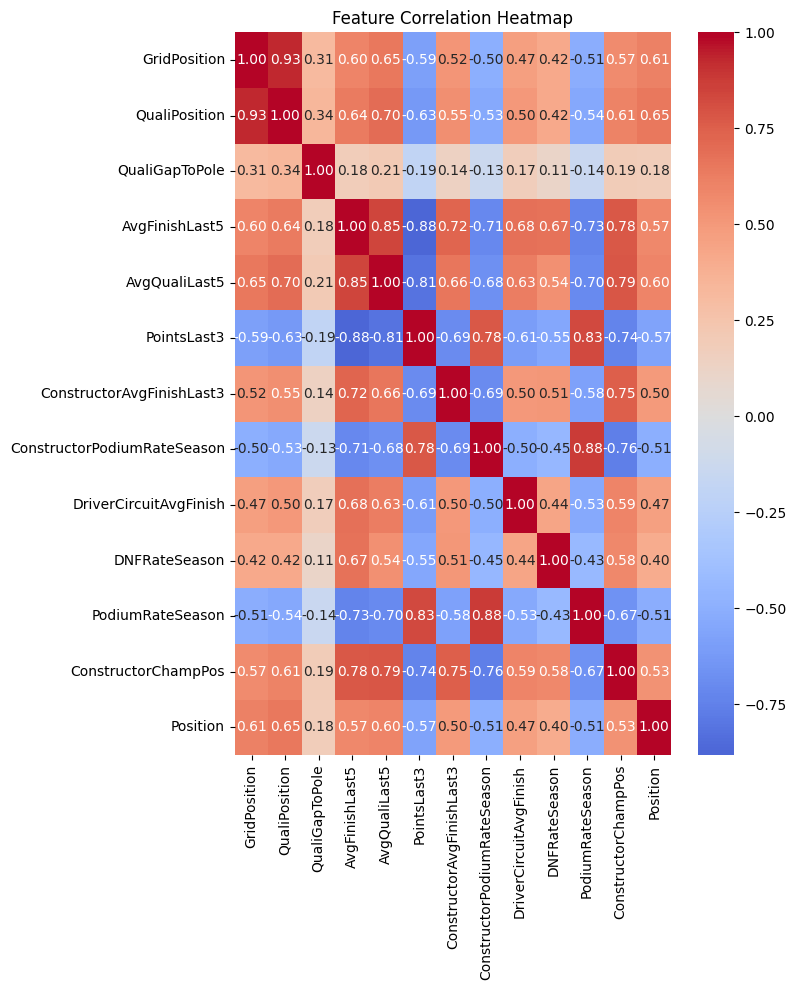

In [12]:
# Which features correlate most with finish position?

feature_cols = [
    'GridPosition',
    'QualiPosition',
    'QualiGapToPole',
    'AvgFinishLast5',
    'AvgQualiLast5',
    'PointsLast3',
    'ConstructorAvgFinishLast3',
    'ConstructorPodiumRateSeason',
    'DriverCircuitAvgFinish',
    'DNFRateSeason',
    'PodiumRateSeason',
    'ConstructorChampPos',
]

# Calculate correlations with finish position
correlations = df[feature_cols + ['Position']].corr()['Position'].sort_values(ascending=False)

print("Feature correlations with finish position:")
print(correlations)

# Heatmap
plt.figure(figsize=(8, 10))
sns.heatmap(
    df[feature_cols + ['Position']].corr(),
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0
)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [13]:
# Check for NaN values
print("Missing values per feature:")
print(df[feature_cols].isnull().sum())

# Fill any remaining NaNs with reasonable defaults
df['AvgFinishLast5'] = df['AvgFinishLast5'].fillna(11)  # Midfield
df['AvgQualiLast5'] = df['AvgQualiLast5'].fillna(11)
df['PointsLast3'] = df['PointsLast3'].fillna(0)
df['ConstructorAvgFinishLast3'] = df['ConstructorAvgFinishLast3'].fillna(11)
df['ConstructorPodiumRateSeason'] = df['ConstructorPodiumRateSeason'].fillna(0)

print("\n✅ Missing values handled")
print(df[feature_cols].isnull().sum())

Missing values per feature:
GridPosition                    2
QualiPosition                   1
QualiGapToPole                 19
AvgFinishLast5                 31
AvgQualiLast5                  31
PointsLast3                    31
ConstructorAvgFinishLast3      13
ConstructorPodiumRateSeason    40
DriverCircuitAvgFinish         31
DNFRateSeason                   0
PodiumRateSeason                0
ConstructorChampPos             0
dtype: int64

✅ Missing values handled
GridPosition                    2
QualiPosition                   1
QualiGapToPole                 19
AvgFinishLast5                  0
AvgQualiLast5                   0
PointsLast3                     0
ConstructorAvgFinishLast3       0
ConstructorPodiumRateSeason     0
DriverCircuitAvgFinish         31
DNFRateSeason                   0
PodiumRateSeason                0
ConstructorChampPos             0
dtype: int64


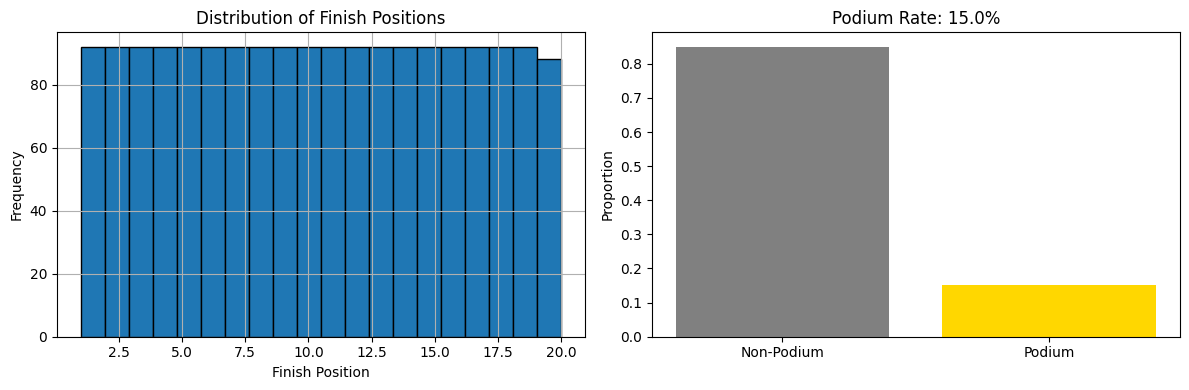


Dataset ready for modeling:
Total rows: 1838
Features: 12
Years: 2022 - 2025


In [14]:
# Distribution of target variable
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['Position'].hist(bins=20, edgecolor='black')
plt.xlabel('Finish Position')
plt.ylabel('Frequency')
plt.title('Distribution of Finish Positions')

plt.subplot(1, 2, 2)
podium_rate = (df['Position'] <= 3).mean()
plt.bar(['Non-Podium', 'Podium'], 
        [1 - podium_rate, podium_rate],
        color=['gray', 'gold'])
plt.ylabel('Proportion')
plt.title(f'Podium Rate: {podium_rate:.1%}')

plt.tight_layout()
plt.show()

print(f"\nDataset ready for modeling:")
print(f"Total rows: {len(df)}")
print(f"Features: {len(feature_cols)}")
print(f"Years: {df['Year'].min()} - {df['Year'].max()}")

In [15]:
# Save the complete feature matrix for modeling
df.to_csv('../data/features_2022_2025.csv', index=False)

print(f"✅ Saved features_2022_2025.csv")
print(f"   Shape: {df.shape}")
print(f"   Features: {feature_cols}")

✅ Saved features_2022_2025.csv
   Shape: (1838, 28)
   Features: ['GridPosition', 'QualiPosition', 'QualiGapToPole', 'AvgFinishLast5', 'AvgQualiLast5', 'PointsLast3', 'ConstructorAvgFinishLast3', 'ConstructorPodiumRateSeason', 'DriverCircuitAvgFinish', 'DNFRateSeason', 'PodiumRateSeason', 'ConstructorChampPos']
